# Mapas de Saliência

08/2020

# Resumo


Nesse notebook serão apresentados os Mapas de Saliência, que são uma técnica de visualização de Redes Neurais Convolucionais que tem como objetivo entender melhor como se dá o aprendizado nesse tipo de Rede Neural.

# Sumário

 <ol>
<li>Introdução</li>
<li>O Mapa de Saliências</li>
<li>Exemplo: Mapa de Saliências de uma Rede Pré-treinada</li>
<li>Smooth Grad</li>
<li>Bibliografia</li>
</ol>


## 1.Introdução

Com a utilização cada vez mais recorrente de Redes Neurais Convolucionais (CNNs) em problemas de classificação de imagens nos últimos anos, surgiu a necessidade de se compreender como se dá o aprendizado nesse tipo de Rede Neural. Algumas técnicas surgiram com o objetivo de se buscar um entendimento maior sobre o funcionamento e o comportamento interno desses modelos complexos. 

As várias técnicas de visualização em CNNs, como são chamadas, abordam o problema de diferentes maneiras, seja gerando imagens que maximizam a ativação de determinada classe em uma rede neural, ou até reconstruindo as imagens de entrada baseados na saída do modelo. O método que será abordado aqui gera um mapa que mostra a contribuição de cada pedaço de uma imagem para a determinação de sua classe por uma CNN. Essa técnica é chamada de Mapa de Saliências de imagem específica (Image-specific class saliency map).



## 2.O Mapa de Saliências

O Mapa de Saliências em Redes Neurais Convolucionais, foi primeiramente definido em 2013 no paper "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps" [1], os autores perceberam que, ao se calcular o gradiente de uma classe em relação a uma imagem para um modelo pré treinado, é possível identificar quais regiões da imagem contribuem para que a Rede Neural preveja a classe que ela pertence.


Dada uma imagem $ I_0 $ e uma classe $ c $ de um modelo de CNN, com uma função "score" $ S_c(I) $ que da um valor de uma imagem para uma determinada classe (a saída da Rede Neural), o objetivo é identificar a influência de cada pixel da imagem $ I_0 $, para o score $ S_c(I_0) $.

### 2.1.Do modelo simples ao complexo

Começando com uma simplificação, vamos considerar o modelo linear para a classe c:

$$ S_c(I) = w^TI+ b_c $$

Sendo $ w^T $ o vetor de pesos e $ b_c $ o "bias" do modelo. Nesse caso, é fácil identificar que os pesos $ w $ definem a importância de cada pixel para a classificação da classe c. Também podemos identificar que $ w = \frac{\partial S_c}{\partial I} \Big|_{I = I_0} $, ou seja, o vetor de pesos é a derivada de $ S_c $ em relação a $ I $ para a imagem $ I_0 $.

Passando para o caso das CNNs, a função score $ S_c(I) $ é altamente não linear, portanto não seria simples de se fazer um paralelo com o resultado anterior. Contudo, é possível dado uma imagem $ I_0 $ que aproximemos a função $ S_c $ nos arredores de $ I_0 $ calculando a expansão de taylor de primeiro grau, chegando a:

$$ S_c(I) \approx w^TI+ b $$

Com isso podemos ter a mesma interpretação de $ w $ como uma derivada:

$$ w = \frac{\partial S_c}{\partial I} \Big|_{I = I_0} $$

Uma outra maneira de interpretar o cálculo do mapa de saliências com essa derivada, é entender que a derivada de $ S_c $ indica qual pixel da imagem precisa de menos variação para ter um grande efeito no score. Vamos ver quando esses mapas forem gerados, que esses pixels correspondem a posição do objeto classificado na imagem.


### 2.2.Extração da Saliência

Partindo do entendimento da última seção, podemos computar o Mapa de Saliências $ M \in \mathbb{R}$ como em [1]. Primeiro calcula-se $ w $ por retropropagação e se reorganiza os valores de $ w $ de modo que o número de elementos de $ M $ seja o número de pixels de $ I_0 $.

No caso de imagens em escala de cinza, o mapa de saliências pode ser calculado como $ M_{ij} = \left| w_{h(i,j)} \right| $ sendo que $ h(i,j) $ representa o pixel de linha $i$ ecoluna $j$ de $ w $. Já para imagens com vários canais de cores, para calcular um único Mapa de Saliência para uma determinada imagem, se calcula $ M_{ij} = max_c (\left| w_{h(i,j,c)} \right|)  $ sendo $c$ a cor de determinado pixel $h(i,j) $ da imagem.

## 3.Exemplo: Mapa de Saliências de uma Rede Pré-treinada

Nesse notebook, será demonstrado na prática a técnica de Mapa de Saliências utilizando o Keras-vis. Para tal, será calculado o mapa de saliências para um modelo já treinado de classificação entre imagens de cachorros e gatos. Espera-se visualizar os pixels que mais contribuem para a decisão de classificação do modelo.

### 3.1.O código

Inicialmente instalaremos o keras-vis

In [ ]:
%reload_ext autoreload
%autoreload 2

!pip install tf-keras-vis tensorflow

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

     |████████████████████████████████| 53 kB 1.5 MB/s 
Tensorflow recognized 0 GPUs


Agora carregaremos o modelo já treinado de classificação de cachorros vs gatos:



In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cats_and_dogs_v4.h5 to cats_and_dogs_v4.h5


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('cats_and_dogs_v4.h5')
#model = load_model('cats_and_dogs_small_2.h5')

Visualizando a arquitetura do modelo:

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

Para fazer o download das imagens, utilizaremos o kaggle:

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir $HOME/.kaggle
!mv kaggle.json $HOME/.kaggle/kaggle.json
!chmod 600 $HOME/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq /content/train.zip -d /datalab/ 

replace /datalab/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Organizando em Pastas:

In [ ]:
import os, shutil

original_dataset_dir = '/datalab/train/'


dir_base = '/content/processed_datalab'
if not os.path.exists(dir_base):
    os.mkdir(dir_base)

dir_treino = os.path.join(dir_base, 'train')
if not os.path.exists(dir_treino):
    os.mkdir(dir_treino)

train_cats_dir = os.path.join(dir_treino, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(dir_treino, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)


fnames = ['cat.{}.jpg'.format(i) for i in [100, 110]]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

    
fnames = ['dog.{}.jpg'.format(i) for i in range(47,48)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    

In [ ]:
import os
import numpy as np

base_dir = dir_base
train_dir = os.path.join(base_dir, 'train')

Com isso podemos visualizar as imagens originais:

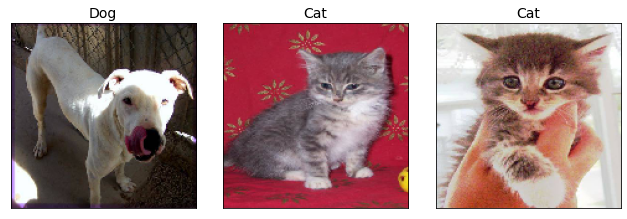

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['Dog', 'Cat', 'Cat']

# Load images
img1 = load_img('/content/processed_datalab/train/cats/cat.100.jpg', target_size=(150, 150))
img2 = load_img('/content/processed_datalab/train/cats/cat.110.jpg', target_size=(150, 150))
img3 = load_img('/content/processed_datalab/train/dogs/dog.47.jpg', target_size=(150, 150))
images = np.asarray([np.array(img3), np.array(img2), np.array(img1)])

# Preparing input data
#X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

Para tornar possível que nossa rede neural receba essas imagens como input, precisamos pré processá-las. Utilizaremos a função ImageDataGenerator do Keras:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



Found 3 images belonging to 2 classes.


Utilizaremos a função *model_modifier* para trocar a função de ativação da última camada do modelo, de softmax para linear. 

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

Nós precisamos definir uma função custo, essa função está ligada a saída do modelo. Como geraremos três imagens de mapa de saliência, a função terá como saída um vetor de três elementos relacionados a saída do modelo:

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0], output[1], output[2])

from tf_keras_vis.utils.scores import BinaryScore
score = BinaryScore(0.0) # or BinaryScore(False) 

def loss(output):
    return (output[0], -1*output[1], -1*output[2])

Agora, utilizando a função *Saliency*, criaremos o mapa de saliência das três imagens:

In [ ]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

In [ ]:
saliency_map = saliency(loss, train_generator[0][0][0:3])

#saliency_map = saliency(loss, train_generator[0][0][0:3])
#saliency_map = normalize(saliency_map)

Então podemos renderizar os mapas de saliência gerados:

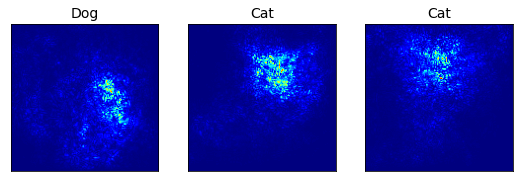

In [ ]:

subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
image_titles = ['Dog', 'Cat', 'Cat']
f, ax = plt.subplots(**subplot_args)

for i, title in enumerate(image_titles):
  ax[i].set_title(title, fontsize=14)
  ax[i].imshow(saliency_map[i], cmap='jet')




In [ ]:
image_titles[1]

'Cat'

### 3.2.Análise do mapa de Saliências

Por mais que o Mapa de Saliências faça um bom trabalho em mostrar os pixels que mais "ativam" a sensibilidade do modelo, podemos perceber que ele tem seus defeitos. Olhando para as imagens geradas acima, podemos ver que há um excesso de ruído, fazendo que por vezes seja difícil até identificar a imagem orignal, e onde está a ativação.

Isso se dá pelo fato da possibilidade da função $ S_c $ ter altas variações em pequenas escalas. Ou seja, parte desses pixels salientados não tem necessariamente a ver com a ativação do modelo, mas sim com variações sem significado nas derivadas parciais.





## 4.Smooth Grad

A técnica chamada *SmoothGrad* surgiu com o objetivo de atenuar o ruído nos mapas de saliência. Após algumas análises experimentais de cálculo do gradiente em algumas imagens, se percebeu que uma média local de valores de $ S_c $ conteria mais significado em termos da imagem, diminuindo variações sem sentido nas derivadas partuais.

Como o cálculo direto de uma média local de um espaço de várias dimensões como uma imagem tem um custo muito alto, a maneira utilizada para lidar com esse problema foi o cálculo de uma aproximação estocástica dessa média. Na prática se calcula o Mapa de Saliências $ M_{ij} $ para $ n $ amostras aleatórias nos arredores da imagem $ I $, e no fim pega-se a média desses mapas resultantes. Isso pode ser expresso matematicamente da seguinte maneira:

$$ \hat{M}_{ij}(I) = \frac {1}{n} \sum \limits_1^n M_{ij}(I + \mathcal{N}(0,\sigma^2))$$

Sendo $ \mathcal{N}(0,\sigma^2) $ o ruído gaussiano com média $0$ e desvio padrão $ \sigma $.

### 4.1.Escolha dos Hiper-Parâmetros

A técnica *SmoothGrad* envolve 2 hiper-parâmetros, sendo eles o número de amostras $ n $ e o desvio padrão $ \sigma $ do ruído. Como na escolha dos hiper-parâmetros de redes neurais comuns, não há regra e nem demonstração que nos guie para essas escolhas. As decisões devem ser tomadas de maneira empírica e devem variar para cada tipo de imagem/modelo.

Segundo os testes feitos em [2], bons valores para $ \sigma $ variam entre $0,2$ e $0,3$. Já para $ n $ a tendência é que quanto maior for o número de amostras, menos ruído o mapa de salíências terá (como o esperado), porém, os resultados mostram que a partir de $ n = 50 $, as mudanças deixam de ser significativas.


### 4.2.Exemplo de SmoothGrad


Para utilizar o SmoothGrad com o Keras-vis, utilizaremos o *saliency_map* indicando o número de smooth_samples ($ n $) e um valor para *smooth_noise* ($\sigma$). Para esse caso utilizaremos $ n = 20$ e $ \sigma = 0,2$.

In [ ]:
# Create Saliency object.
#saliency = Saliency(model,
#                    model_modifier=model_modifier,
#                    clone=False)


saliency_map2 = saliency(loss,
                        train_generator[0][0][0:3],
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.


# Generate saliency map with smoothing that reduce noise by adding noise
#saliency_map2 = saliency(loss,
#                        train_generator[0][0][0:3],
#                        smooth_samples=20, # The number of calculating gradients iterations.
#                        smooth_noise=0.20) # noise spread level.
#saliency_map2 = normalize(saliency_map2)



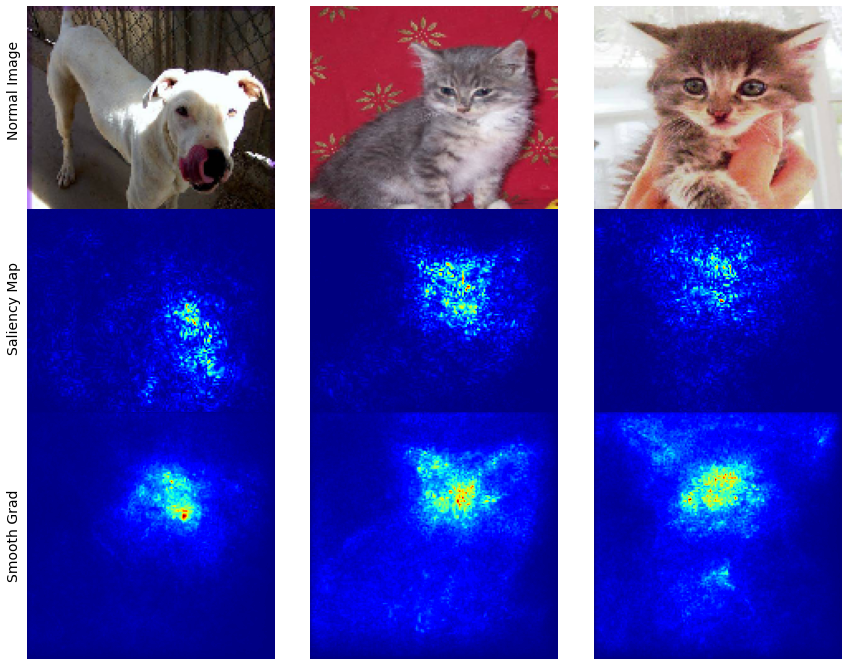

In [ ]:

plt.figure(figsize=(18,12)) # specifying the overall grid size

image_titles = ['Cachorro', 'Gato', 'Gato']

for i in range(3):
  plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  #plt.title(image_titles[i], fontsize=14)
  if i == 0:
    plt.title("Normal Image", rotation='vertical', x=-0.05, y=0.45, fontsize = 14)
  plt.axis('off')


for i in range(3):
  plt.subplot(3,3,i+4)    # the number of images in the grid is 5*5 (25)
  plt.imshow(saliency_map[i], cmap='jet')
  if i == 0:
    plt.title("Saliency Map", rotation='vertical', x=-0.05, y=0.4, fontsize = 14)

  
  plt.axis('off')


for i in range(3):
  plt.subplot(3, 3, i+7)
  plt.imshow(saliency_map2[i], cmap='jet')
  if i == 0:
    
    plt.title("Smooth Grad", rotation='vertical', x=-0.05, y=0.3, fontsize = 14)

  plt.axis('off')


plt.subplots_adjust(wspace=-0.35)
plt.subplots_adjust(hspace=-0.18)
plt.show()

## 5.Bibliografia

[1] https://arxiv.org/abs/1312.6034

[2] https://arxiv.org/abs/1706.03825

[3] https://pypi.org/project/tf-keras-vis/

[4] https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

[5] https://www.kaggle.com/c/dogs-vs-cats

[6] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

[7] https://github.com/fchollet/deep-learning-with-python-notebooks
